#**Model**



In [ ]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [ ]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle

In [ ]:
# 내 드라이브에 대한 주소
path = "/gdrive//My Drive/dacon_news/"

train = pd.read_csv(path + "data/news_train.csv")
test = pd.read_csv(path + "data/news_test.csv")

# content 맨앞이 [이거나 (이거나 제목이면 0

In [ ]:
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0

# 타이틀을 이용한 feature
- 해당 title에 몇가지 단어가 들어갈 경우 약 90% 이상이 info가 1

In [ ]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x[-6:]) or ("관련주" in x[-5:]):
    return 1
  for noise in title_noise:
    if noise in x.upper():
        return 1
  return 0

In [ ]:
train["info1_title"]=train['title'].apply(title_choose)

# content를 이용한 feature

In [ ]:
content_noise = ['00%','긴급공개', '긴급 공개','임상3상','# ','대장株','대장주','카톡','원"만','TOP','BEST']

def content_choose(x):
  if (x=='관련기사') or (x=="관련 테마분석") or (x=="코스피") or (x=="코스닥"):
    return 1
  for noise in content_noise:
    if noise in x.upper():
        return 1
  return 0

In [ ]:
train["info1_content"]=train["content"].apply(content_choose)

# Order을 이용한 feature

In [ ]:
title_group = (train.groupby(["title"]).count())["n_id"]
train["new_ord"]=train.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

# tokenization

In [ ]:
from konlpy.tag import Mecab
import re

def text_preprocessing(text_list):

    tokenizer = Mecab() #형태소 분석기

    token_list = [] 
    
    for text in text_list:
        txt = re.sub("[a-zA-Z0-9]", ' ', text) #영문, 숫자 제거 -> 특수문자는 제거하지 않음
        txt = re.sub('[가-힣]+\s기자','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        token = [t for t in token] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다.
train['new_article'], mecab = text_preprocessing(train['content'])

In [ ]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

# Vectorization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 100

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len, truncating="pre") # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = max_len)

print(train_X.shape, train_y.shape)

vocab_size :  33519
(118676, 100) (118676,)


In [ ]:
# vectorizer 저장
joblib.dump(vectorizer, "vectorizer.sav")

['vectorizer.sav']

#train test split

In [ ]:
#concat
feature_num = 4
train_X = np.concatenate([train_X,train[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)

# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

# 모델 생성

In [ ]:
# EDA기반으로 만든 feature 예측변수로 추가한 모델 생성
from keras import regularizers

def LSTM_add_feature(vocab_size, embedding_size = 100, max_len=100):
  input1 = keras.layers.Input(shape = [max_len,]) #문장 단어 input
  input2 = keras.layers.Input(shape = [feature_num,]) # EDA기반 feature input

  # LSTM
  embedding = keras.layers.Embedding(vocab_size, embedding_size, input_length = max_len)(input1) # 임베딩 가중치 훈련
  dropout1 = keras.layers.SpatialDropout1D(0.5)(embedding)
  lstm1 = keras.layers.LSTM(32, return_sequences = True)(dropout1)
  lstm2 = keras.layers.LSTM(32)(lstm1)
  dropout2 = keras.layers.Dropout(0.5)(lstm2)

  # MLP
  concat = keras.layers.concatenate([dropout2,input2])
  hidden = keras.layers.Dense(32, activation = "selu")(concat)
  output = keras.layers.Dense(1, activation = "sigmoid")(hidden)

  model = keras.Model(inputs = [input1, input2], outputs = [output])

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model

# 모델 훈련 및 검증

In [ ]:
# 훈련 시
tf.random.set_seed(42)
embedding_size = 300

checkpoint_cb = keras.callbacks.ModelCheckpoint("hyerim_add_feature_best_model2.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 3
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len, embedding_size = embedding_size)
history = model.fit(x=[X_train[:,:max_len],X_train[:,-feature_num:]], y=y_train, epochs=max_epoch,
                batch_size = batch_size,  validation_data = ((X_valid[:,:max_len],X_valid[:,-feature_num:]),y_valid), validation_batch_size = batch_size,
                 callbacks = [checkpoint_cb])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     10055700    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100, 32)      42624       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

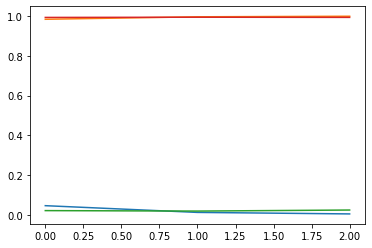

In [ ]:
best_model = keras.models.load_model("hyerim_add_feature_best_model2.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history)) 

In [ ]:
# 성능
best_model.evaluate((X_valid[:,:max_len],X_valid[:,-feature_num:]),y_valid)

1113/1113 [==============================] - 8s 7ms/step - loss: 0.0207 - accuracy: 0.9931


[0.020706063136458397, 0.9930904507637024]

# 모델 최종 훈련

In [ ]:
# 실제 예측시
# 학습속도를 높이기 위한 index 재정렬
index_seq = (train_X.argmax(axis=1)).argsort(axis=0)
sort_train_X = train_X[index_seq]
sort_train_y = train_y.iloc[index_seq]

tf.random.set_seed(2020)

# 하이퍼파라미터
max_epoch = 2
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len, embedding_size = embedding_size)
history = model.fit(x=[sort_train_X[:,:-feature_num],sort_train_X[:,-feature_num:]], y=sort_train_y,epochs=max_epoch,batch_size = batch_size)


Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 100, 300)     10055700    input_65[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_28 (SpatialDr (None, 100, 300)     0           embedding_28[0][0]               
__________________________________________________________________________________________________
lstm_56 (LSTM)                  (None, 100, 32)      42624       spatial_dropout1d_28[0][0]       
___________________________________________________________________________________________

In [ ]:
# lstm 모델 저장
model.save("lstm_model.h5")

# 전문장, 전전문장의 예측결과값을 이용하여 예측값 보정

In [ ]:
lstm_model = keras.models.load_model("lstm_model.h5")

In [ ]:
# LSTM을 통한 예측
train_predicted = lstm_model.predict((train_X[:,:max_len],train_X[:,-feature_num:]))

# 각 문장의 바로 앞문장과, 그 앞 문장의 예측값 생성
train_pre_predicted1 = np.array([train_predicted[idx-1][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞문장
train_pre_predicted2 = np.array([train_predicted[idx-2][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞앞문장

# 학습을 위한 데이터셋 생성
train["predicted"]=train_predicted
train["pre_predicted1"]=train_pre_predicted1
train["pre_predicted2"]=train_pre_predicted2

# ord가 1,2 인 것은 학습에서 제외 후 최종 lgbm 훈련을 위한 데이터셋 생성
final_X = train[["predicted","pre_predicted1","pre_predicted2"]][(train["ord"]!=1)&(train["ord"]!=2)]
final_y = train["info"][(train["ord"]!=1)&(train["ord"]!=2)]
final_X_train, final_X_valid, final_y_train, final_y_valid = train_test_split(final_X, final_y,test_size = 0.3, random_state = 42)

In [ ]:
# LGBM 모델 불러오기
from lightgbm import LGBMClassifier

# index 랜덤으로 섞음
np.random.seed(42)
random_index = np.random.randint(0,len(final_X),len(final_X))

# LGBM model 예측
lgbm_model=LGBMClassifier(random_state=42)
lgbm_model.fit(final_X.iloc[random_index], y=final_y.iloc[random_index])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# lgbm 모델 저장
joblib.dump(lgbm_model, 'lgbm_model.pkl')

['lgbm_model.pkl']

# test 예측

In [ ]:
path = "/gdrive/My Drive/dacon_news/"
feature_num = 4
test = pd.read_csv(path+"data/news_test.csv")

# EDA 기반 feature 추가
test["info1_title"]=test["title"].apply(title_choose)
test["info1_content"]=test["content"].apply(content_choose)
test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[") or str(x).startswith("(") or str(x).startswith("제목"))+0
title_group = (test.groupby(["title"]).count())["n_id"]
test["new_ord"]=test.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

# 전처리
test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = max_len) # 길이를 맞춰줌

# concat
test_X = np.concatenate([test_X,test[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)

In [ ]:
# lstm 모델을 통한 예측
predicted = lstm_model.predict([test_X[:,:max_len],test_X[:,-feature_num:]])

In [ ]:
# 앞문장, 앞앞문장으로 최종 예측
pre_predicted1 = np.array([predicted[idx-1][0] for idx in range(len(predicted))]).reshape(-1,1) # 앞문장
pre_predicted2 = np.array([predicted[idx-2][0] for idx in range(len(predicted))]).reshape(-1,1) # 앞앞문장

test["predicted"]=predicted
test["pre_predicted1"]=pre_predicted1
test["pre_predicted2"]=pre_predicted2

lgbm_final_predicted = lgbm_model.predict(test[["predicted","pre_predicted1","pre_predicted2"]])

In [ ]:
# ord가 1,2인 것은 lstm모델만을 통해 예측, threshold 0.6으로 분류
test["info"]=lgbm_final_predicted
test["info"][test["ord"]==1]=(test["predicted"][test["ord"]==1]>=0.6)+0
test["info"][test["ord"]==2]=(test["predicted"][test["ord"]==2]>=0.6)+0
test["info"][test["content"].apply(lambda x: True if ('http://etoday.bujane.co.kr/' in x) or ('http://bit.ly/2XrAuGJ_itoozanews' in x) or ('http://www.hisl.co.kr/0306/' in x) or ('https://www.hankyung.com/election2020/' in x) or (x==']]') else False)]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Submission

In [ ]:
submission = pd.read_csv(path+"/data/sample_submission.csv")
submission.to_csv("submission.csv", encoding="utf-8-sig",index=False)

In [ ]:
# 구글 word2vec 모델

#word2vec_g = gensim.models.KeyedVectors.load_word2vec_format(path+'embedding/GoogleNews-vectors-negative300.bin.gz', binary = True)
#embedding_size = 300

In [ ]:
# 한국어 word2vec model
#word2vec2 = gensim.models.Word2Vec.load(path+'embedding/ko.bin')
#embedding_size = 200

In [ ]:
# glove model
"""
2. # load the whole embedding into memory
glove = dict()
embedding_size = 100
f = open(path+'embedding/word-embeddings/glove/glove.txt')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove[word] = vector
f.close()
"""